***Setup***

In [3]:
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
from PIL import Image

os.makedirs("images", exist_ok=True)

***Hyper-parameter Setting***

In [37]:
n_epochs = 50
img_shape = (1, 28, 28)
latent_dim = 6
Batch_Size = 128
lr = 1e-5
b1 = 0.9
b2 = 0.99

cuda = True if torch.cuda.is_available() else False

**Generator**

In [38]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

**Discriminator**

In [39]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

**Loss Function and Loading Data**

In [40]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(28), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=Batch_Size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

**Training Loop**

In [41]:
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Tensor(imgs.size(0), 1).fill_(1.0).cuda()
        fake = Tensor(imgs.size(0), 1).fill_(0.0).cuda()

        # Configure input
        real_imgs = imgs.type(Tensor).cuda()

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))).cuda()

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch + 1, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % 2000 == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

Streaming output truncated to the last 5000 lines.
[Epoch 40/50] [Batch 159/469] [D loss: 0.215750] [G loss: 1.605864]
[Epoch 40/50] [Batch 160/469] [D loss: 0.178299] [G loss: 1.851635]
[Epoch 40/50] [Batch 161/469] [D loss: 0.178059] [G loss: 2.258912]
[Epoch 40/50] [Batch 162/469] [D loss: 0.203072] [G loss: 2.437484]
[Epoch 40/50] [Batch 163/469] [D loss: 0.227647] [G loss: 2.217190]
[Epoch 40/50] [Batch 164/469] [D loss: 0.188874] [G loss: 1.696592]
[Epoch 40/50] [Batch 165/469] [D loss: 0.202141] [G loss: 1.535307]
[Epoch 40/50] [Batch 166/469] [D loss: 0.205319] [G loss: 1.671248]
[Epoch 40/50] [Batch 167/469] [D loss: 0.186027] [G loss: 2.035927]
[Epoch 40/50] [Batch 168/469] [D loss: 0.226359] [G loss: 2.447237]
[Epoch 40/50] [Batch 169/469] [D loss: 0.219001] [G loss: 2.150002]
[Epoch 40/50] [Batch 170/469] [D loss: 0.209824] [G loss: 1.870148]
[Epoch 40/50] [Batch 171/469] [D loss: 0.186974] [G loss: 1.505340]
[Epoch 40/50] [Batch 172/469] [D loss: 0.185190] [G loss: 1.64443

**Ploting Images**

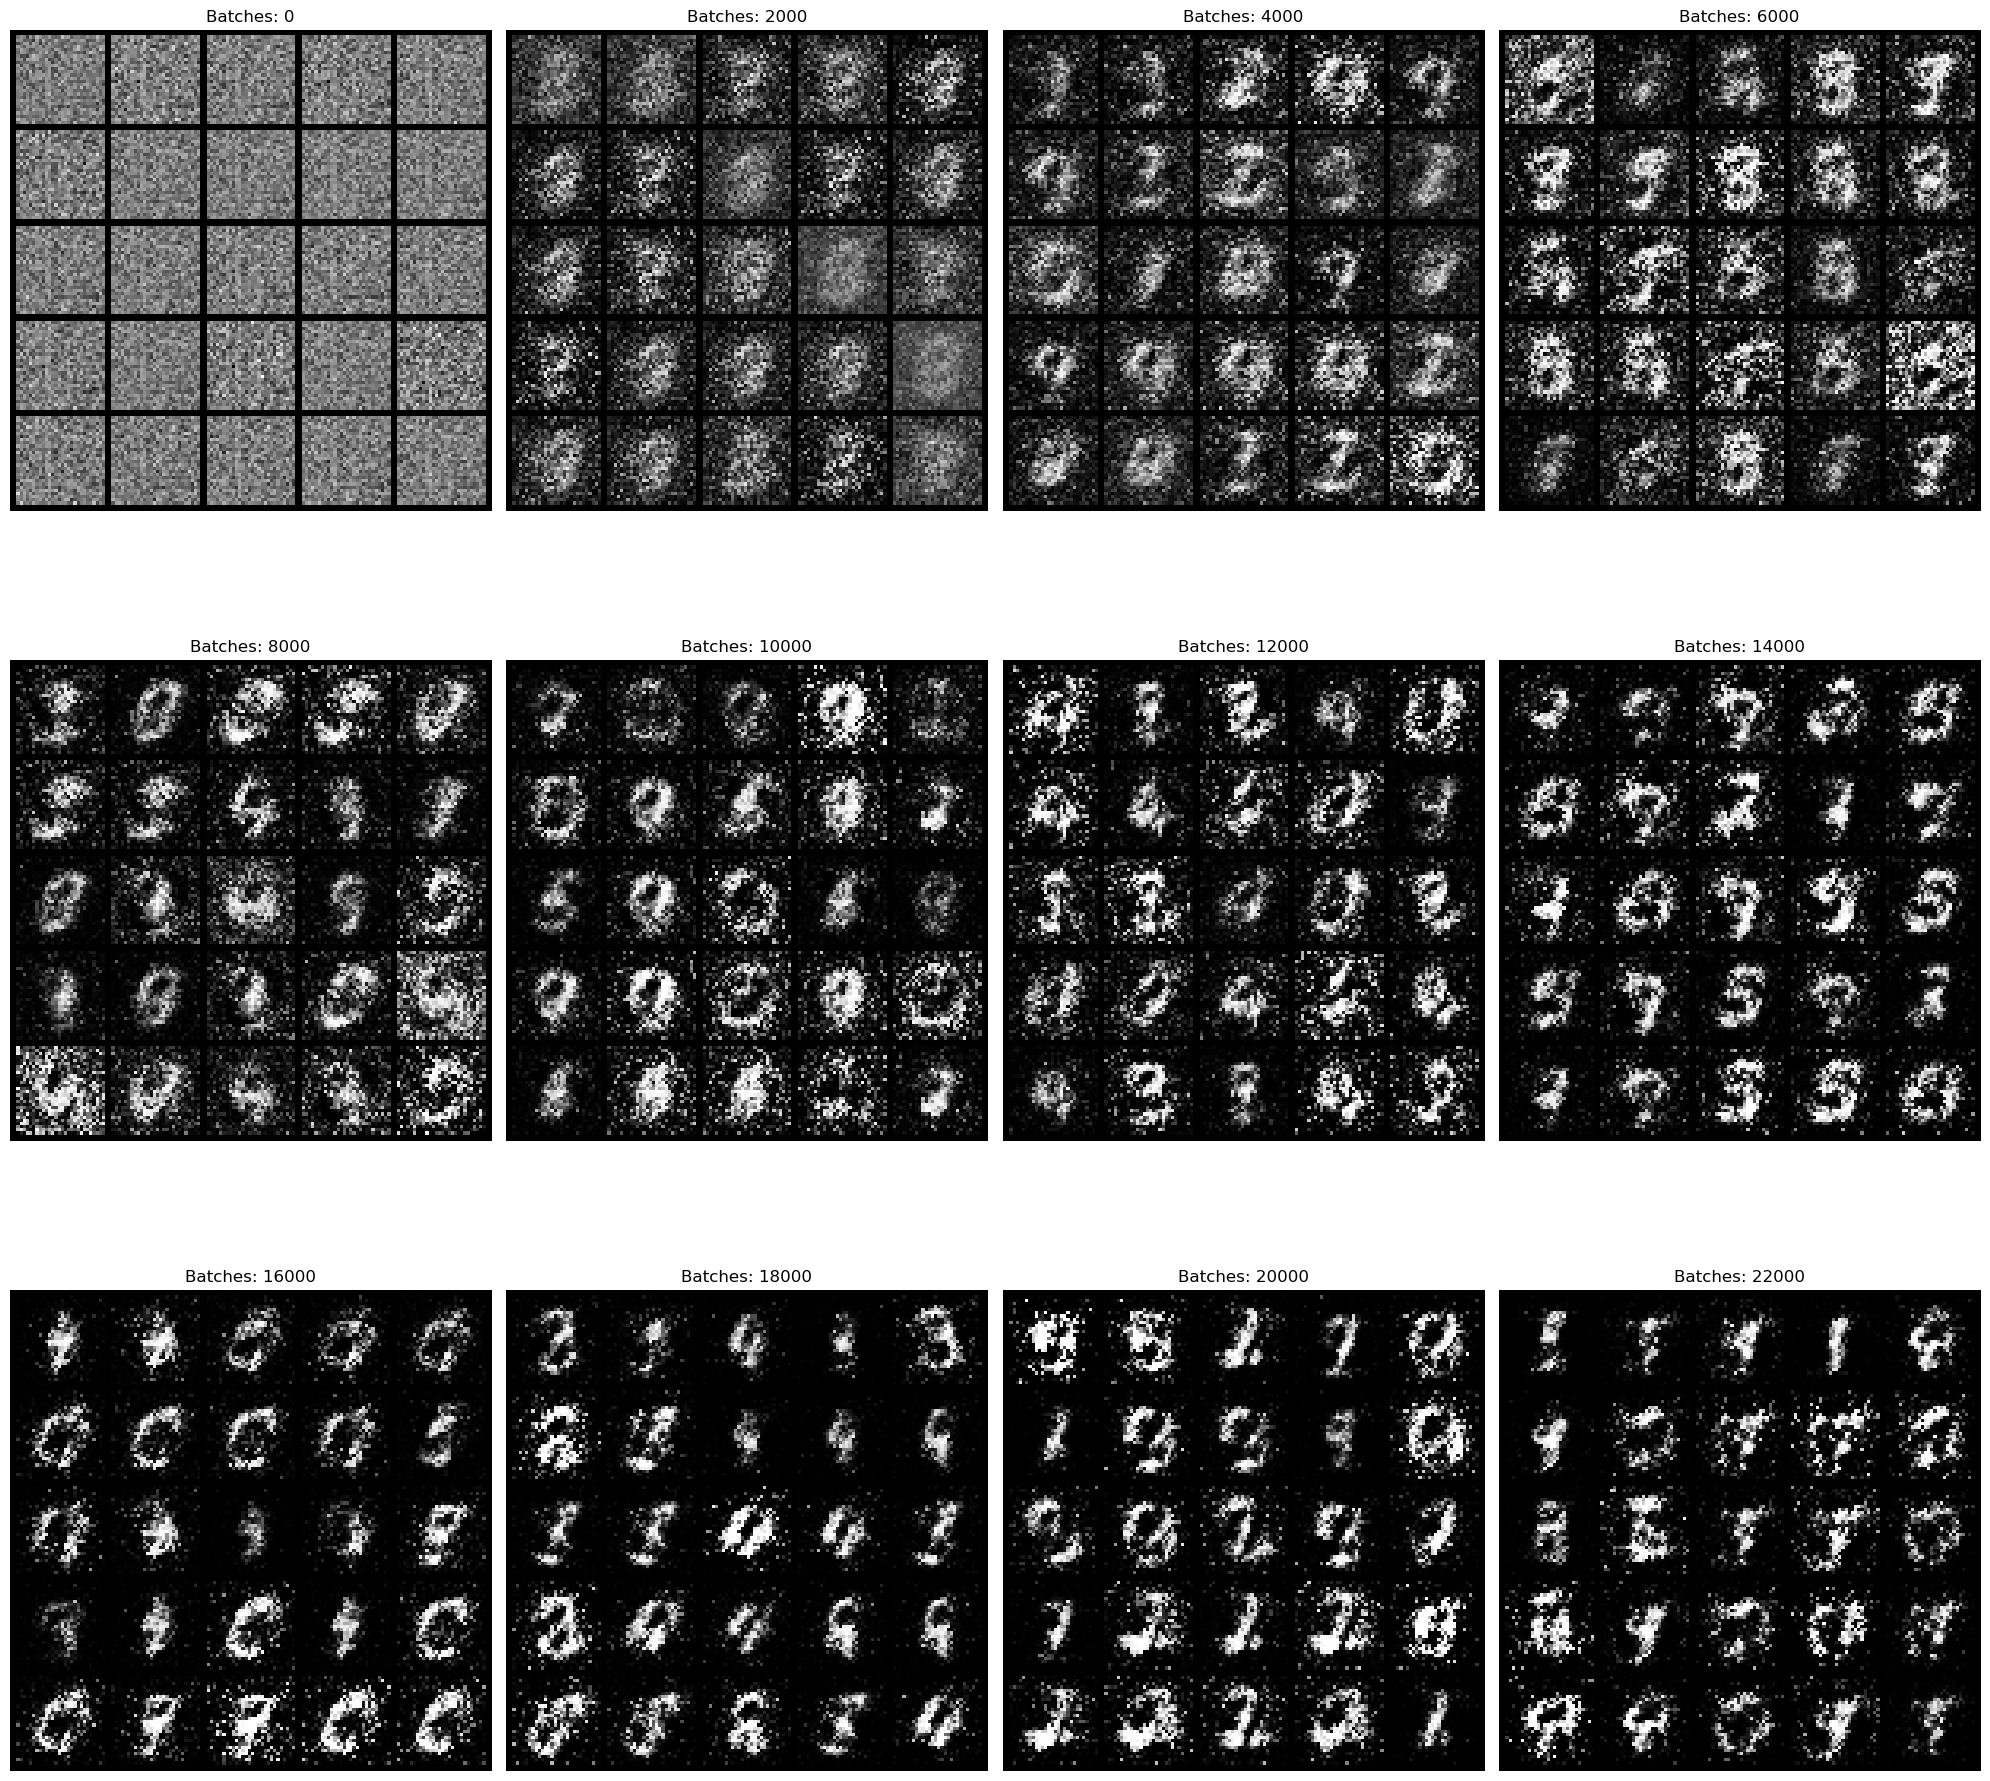

In [5]:
image_dir = 'images'
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')], key=lambda x: int(x.split('.')[0]))
columns = 4
rows = len(image_files) // columns + int(len(image_files) % columns != 0)

fig, axes = plt.subplots(rows, columns, figsize=(20, 20))
axes = axes.flatten()

for ax, image_file in zip(axes, image_files):
    img = Image.open(os.path.join(image_dir, image_file))
    ax.imshow(img)
    batch_number = os.path.splitext(image_file)[0]
    ax.set_title(f"Batches: {batch_number}")
    ax.axis('off')

for ax in axes[len(image_files):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

In [36]:
# Specify the directory
directory = 'images'

# List all files in the directory
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    try:
        # Check if it is a file (not a directory)
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.remove(file_path)
            print(f"Deleted {file_path}")
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

print("All files have been deleted.")

Deleted images/2000.png
Deleted images/8000.png
Deleted images/6000.png
Deleted images/10000.png
Deleted images/4000.png
Deleted images/0.png
All files have been deleted.
